In [1]:
import tensorflow as tf

In [2]:
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal", use_bias=False
)

In [3]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
    
        self.skip_layers = []
        if strides > 1:
            self.skip_layers= [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Now, we can build the ResNet-34 using Sequential API, since its really just a long sequence of layers--we can treat each residual unit as a single layer now that we have a ResidualUnit class.

In [4]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
])

prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [5]:
model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.SGD(),
    metrics = ["accuracy"]
)

### Laoding The Data

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
DATADIR = "my_img_data"
CATEGORIES = ["not_waiting", "waiting"]

def create_training_data(IMG_SIZE):
    training_data = []
    for category in CATEGORIES:
        class_num = CATEGORIES.index(category)
        path = os.path.join(DATADIR, category)
        for image_name in os.listdir(path):
            image_path = os.path.join(path, image_name)
            try:
                # Load image
                img = cv2.imread(image_path, cv2.IMREAD_COLOR)
                # Resize image while maintaining aspect ratio
                resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                # Normalize pixel values to range [0, 1]
                resized_img = resized_img / 255.0
                # Append resized image and class number to training_data list
                training_data.append([resized_img, class_num])
            except Exception as e:
                # Print error if image loading or resizing fails
                print(f"Error processing image: {image_path}, Error: {str(e)}")
    # Shuffle training_data to ensure randomness
    np.random.shuffle(training_data)
    return training_data

training_img = create_training_data(224)

In [7]:
len(training_img)

135

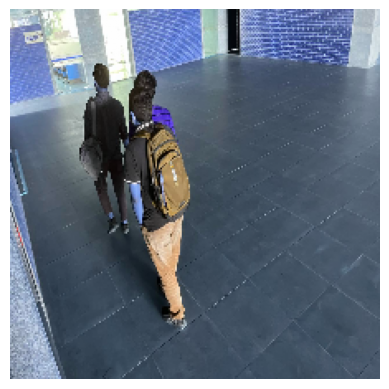

In [8]:
def show_image(img):
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()
    
show_image(training_img[0][0])

In [9]:
training_img[0][0].shape

(224, 224, 3)

### Training The Model

In [10]:
X = np.array([i[0] for i in training_img])
y = np.array([i[1] for i in training_img])

NUM_EPOCHS = 5
history = model.fit(X, y, epochs=NUM_EPOCHS, validation_split=0.05)

Epoch 1/5
4/4 [==============================] - 35s 7s/step - loss: 0.9282 - accuracy: 0.5625 - val_loss: 104.7231 - val_accuracy: 0.5714
Epoch 2/5
4/4 [==============================] - 26s 7s/step - loss: 0.4486 - accuracy: 0.7734 - val_loss: 108.8995 - val_accuracy: 0.5714
Epoch 3/5
4/4 [==============================] - 27s 7s/step - loss: 0.4191 - accuracy: 0.7891 - val_loss: 74.4164 - val_accuracy: 0.5714
Epoch 4/5
4/4 [==============================] - 26s 7s/step - loss: 0.2668 - accuracy: 0.9688 - val_loss: 68.9374 - val_accuracy: 0.5714
Epoch 5/5
4/4 [==============================] - 26s 7s/step - loss: 0.1910 - accuracy: 0.9922 - val_loss: 51.0380 - val_accuracy: 0.5714


In [11]:
X_reshaped = np.expand_dims(X[:10], axis=-1)  # Add channel dimension
predictions = model.predict(X_reshaped)
for prediction in predictions:
    predicted_class = np.argmax(prediction)
    print(predicted_class)

1/1 [==============================] - 1s 1s/step
0
0
0
0
0
0
0
0
0
0


In [12]:
y[:10]

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 0])

Keras provides several these architecture built in. Let's load ResNet-50 model, pretrained model on ImageNet.

In [13]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 175s 2us/step


In [14]:
# ResNet-50 model expects 224 x 224 pixel image, let's check that
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [16]:
def create_training_data(IMG_SIZE):
    training_data = []
    for category in CATEGORIES:
        class_num = CATEGORIES.index(category)
        path = os.path.join(DATADIR, category)
        for image_name in os.listdir(path):
            image_path = os.path.join(path, image_name)
            try:
                img = cv2.imread(image_path, cv2.IMREAD_COLOR)
                training_data.append([img, class_num])
            except Exception as e:
                print(f"Error processing image: {image_path}, Error: {str(e)}")
    np.random.shuffle(training_data)
    return training_data

training_data= create_training_data(224)

In [18]:
training_img = np.array([i[0] for i in training_data])
training_label = np.array([i[1] for i in training_data])

In [21]:
training_img[0].shape

(960, 1280, 3)

Keras Expect the input image pixel to be 244x244, let's make it using Keras layers

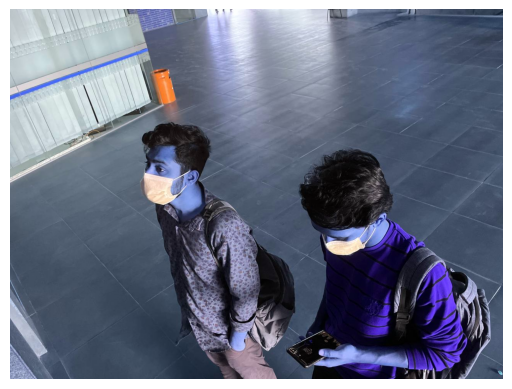

In [24]:
show_image(training_img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


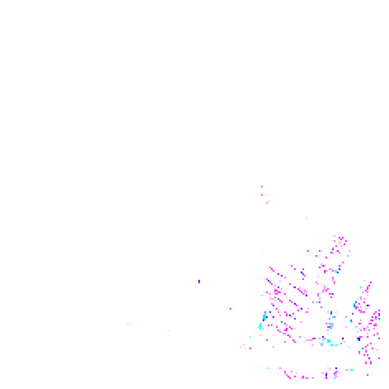

In [25]:
training_img_resized = tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True)(training_img)
show_image(training_img_resized[0])

The pretrained models assume that the images are proprocessed in a specific way. In some cases they may expect the inputs to be scaled between 0 to 1 or -1 to 1. Each model provides preprocess_input() method that you can use to preprocess your images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


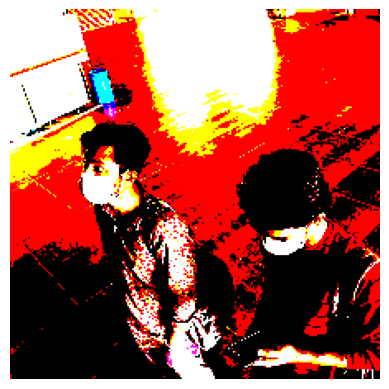

In [26]:
inputs = tf.keras.applications.resnet50.preprocess_input(training_img_resized)
show_image(inputs[0])

In [41]:
y_proba = model.predict(inputs[:3])
y_proba.shape

1/1 [==============================] - 0s 303ms/step


(3, 1000)

The output y_proba is a matrix with one row per image and one column per class(in this case, there 1000 classes). If you want to display top K predictions, including the class name and the estimated probability of each class, use decode_predictions() method.

In [42]:
top_K = tf.keras.applications.resnet50.decode_predictions(y_proba, top=3)
for image_index in range(3):
    print(f"Image #{image_index+1}")
    for class_id, name, y_proba in top_K[image_index]:
          print(f"{class_id} - {name:12s},  {y_proba:2%}")

Image #1
n03814639 - neck_brace  ,  17.313571%
n03160309 - dam         ,  12.360407%
n03249569 - drum        ,  10.613609%
Image #2
n02977058 - cash_machine,  8.013317%
n03623198 - knee_pad    ,  6.806972%
n04557648 - water_bottle,  6.158020%
Image #3
n02977058 - cash_machine,  14.222176%
n04136333 - sarong      ,  10.258866%
n04336792 - stretcher   ,  6.956838%


The model cannot recognize the images because it trained on different classes.